# The force and force gradient from patch potentials

#### This purposes of this notebook are: 
#### (1) to explain what the analysis procedure for the 2-surface patch potential paper is <br>
#### (2) to show how the analysis procedure used is derived from Speake and Trenkel *PRL* 2003 and Behunin *et al* PRA 2012a <br>
#### (3) to provide the code used to convert the patch potential data into forces (NB: this code will take a long time to run, and I suggest that you run it prior to this notebook through the file preprocessing.py) <br>
(c) 2019

## Section I: Introducing patches

#### Patch potentials are regions of conducting surface whose potential differs from neighboring regions. The varying potential is possible because the electron chemical potential can vary across a surface.

#### We measure patch potentials with (heterodyne) Kelvin Probe force microscopy (KPFM), which relies on a feedback loop to detect the contact potential difference between a conductive atomic force microcopy probe and the surface. Because the plates are flat, the KPFM feedback works on them without any difficulty (which is why patch potentials have been measured on plates several times). However, it is more difficult to operate KPFM on a sphere. Even with several of the adaptations for scanning on a curved surface (mentioned in the main text), there are a few locations on the sphere where the feedback loop ceased to operate correctly. These locations are identified through the error signal of the KPFM loop. Essentially, when feedback works by adjusting the voltage on the probe in order to minimize a signal. When that signal is not minimized, we know that the KPFM feedback voltage isn't the actual contact potential difference. The error signal is apparent when the cantilever briefly makes contact with the surface, for example. 

#### The first step in the analysis is loading the raw data and pre-processing it. During KFPM the surface is raster-scanned, and each pixel is recorded twice. The first time is the 'trace' and the second, the 'retrace'. For most pixels, the trace and retrace data are averaged. If the error signal is large in one of them, but not the other, the one with the low error signal is used. If the error signal is sufficiently bad in both of them, then the pixel is filled with a NaN value temporarily, before being filled in with a median filter. A median filter is chosen because it is a way to estimate the value of a pixel based on neighboring values while also preserving boundaries. 

In [1]:
#CypherKPFM is built on the igor package, see https://pypi.org/project/igor/
import CypherKPFM as ck
import matplotlib.pyplot as plt
import importlib as il
import numpy as np
import filters3D as filt3
import force3D as f3
import patchpotentials as pp
import pickle
import tables

In [2]:
#because I have a preferred colormap
%run chlorophyll.py

In [3]:
#because igor (the package) stores the data as a dictionary, we continue to do so
#the 'prep' in the name of the function just refers to a structural rearranging, not anly data analysis
n8B_plate = ck.load_and_prep('n8B_kpfm_surfloc0002.ibw')
n8B_sphere = ck.load_and_prep('n8B_kpfm0013.ibw')

In [4]:
raw_KPFM = ck.get_image(n8B_plate, 'UserIn1Retrace')

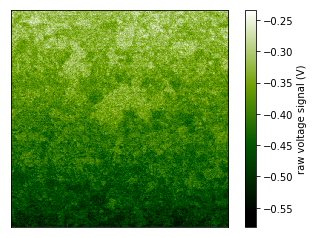

In [5]:
#for now, just note that the length is 10 microns on each side
fig, ax = plt.subplots()
myfig = ax.imshow(raw_KPFM.transpose(), cmap = 'Chlorophyll')
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(myfig, ax = ax, label = 'raw voltage signal (V)')
plt.show()

#### From this first plot of the surface, we can see that there is an overall slope, which we correct for by flattening. When we look at the error signal, note that it is very uniform and shows not systematic deviations.

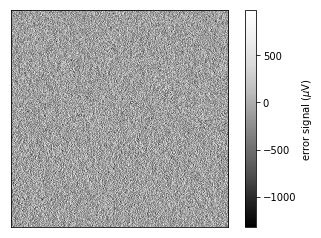

In [6]:
#for now, just note that the length is 10 microns on each side
kpfm_error = 1e6*ck.get_image(n8B_plate, 'UserIn2Retrace')
fig, ax = plt.subplots()
myfig = ax.imshow(kpfm_error.transpose(), cmap = 'Greys_r')
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(myfig, ax = ax, label = 'error signal ($\mu$V)')
plt.show()

#### Because the error signal deviates by less than 1 mV from the setpoint (-180 $\mu$V), the pre-processing is very quick.

#### To clean the data, we identify the locations in the KPFM trace & retrace where the error signal is excessively large. At locations where is is large in only the trace or the retrace, we simply select the pixel from the other channel. When the error is large in both channels, the pixel is replaced by the median of the surrounding pixels. The output of the function below shows that this only happens for 6 pixels, which is pretty good. 

In [7]:
plate_avg = ck.avg_kpfms(n8B_plate)
#plate_clean chooses which pixels (trace or retrace) to average and removes the line noise
plate_clean = ck.clean_kpfms(n8B_plate)

nans: 6, trace: 759, retrace: 719, both: 260660


#### In the output, 'nans' is the number of pixels that had unacceptably large error and had to be median-filled.
#### 'trace' is the number of pixels where the value in the trace was used because of error in the retrace ('retrace' is the opposite).
#### 'both' is the number of pixels for which the trace & retrace were averaged.

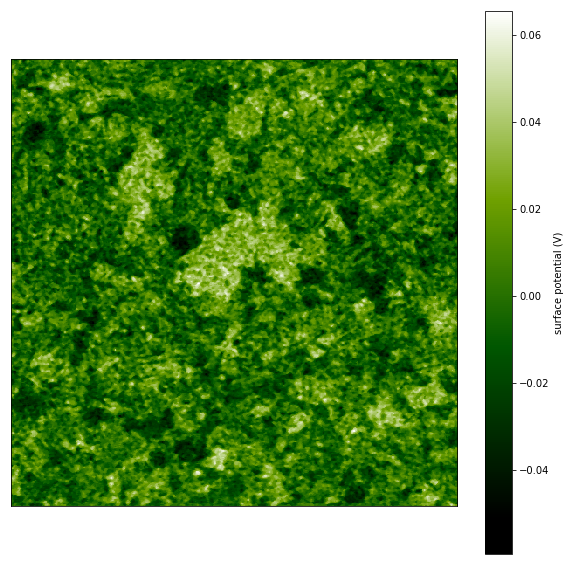

In [8]:
#for now, just note that the length is 10 microns on each side
fig, ax = plt.subplots(figsize = (10,10))
myfig = ax.imshow(plate_clean.transpose(), cmap = 'Chlorophyll', interpolation = 'none')
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(myfig, ax = ax, label = 'surface potential (V)')
plt.show()

#### Now, the KFPM artifacts have been mitigated in the patch data, so that they can be used to calculate the force. The implementation of the preprocessing can be found in the file 'CypherKPFM.py' under the function clean_kpfms().

## Section II: The electrostatic patch force between parallel plates

#### The force from electrostatic patch potentials was first calculated by describing the patches as a dipole layer on the surface of a conductor (Speake and Trenkel *PRL* 2003). The problem was approached in $\it{k}$-space because it permitted a straight-forward way to calculate the patch force between parallel plates. Later, the method to calculate the $\it{k}$-space representation from the $\it{r}$-space representation was derived to facilitate comparison with experiment by Behunin *et al* PRA 2012. 

#### The force from patch potentials is $F_{p} = \frac{-\epsilon_{0}}{2(2\pi)}\int \frac{k^{3}}{\text{sinh}(kD)^{2}}
[C_{11}[k]+C_{22}[k]-2C_{12}[k] \text{cosh}(k_{z}D)]dk$


#### Now, we must compute the autocorrelation functions. Under the assumption of isotropic patches, the autocorrelation functions are radially averaged. 

In [9]:
import patches2D as p2d
plate_ac_line= p2d.autocorrelate_2D_toline(plate_clean)
xaxis = np.array([i for i, x in enumerate(plate_ac_line)])*float(n8B_plate['cleannote']['dx'])*1e9

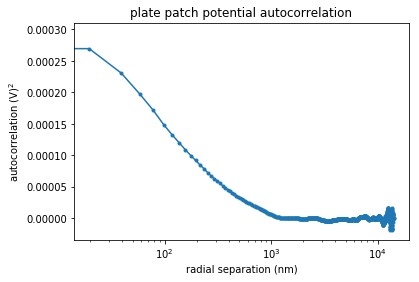

In [10]:
#the autocorrelation function for the plate
plt.semilogx(xaxis,plate_ac_line,'.-')
plt.xlabel('radial separation (nm)')
plt.ylabel('autocorrelation (V)$^{2}$')
plt.title('plate patch potential autocorrelation')
plt.show()

#### One thing to note is the presence of oscillations in the autocorrelation function at separations greater than 5 microns or so. Note that our images only cover an area of 10 x 10 microns, so our estimate of the autocorrelation function at such large separations is bad. In our 2015 paper, we mitigated the effect of those oscillations by limiting the autocorrelation function to half the length of a side of the image.
#### A better way is to use a window function:

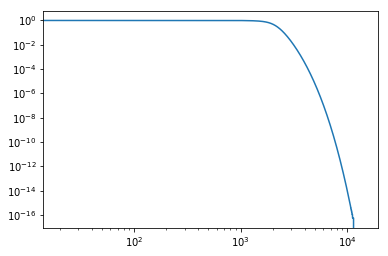

In [11]:
window = np.array([(1-np.tanh((i-2e3)/5e2))/2 for i in xaxis])
plt.loglog(xaxis, window)

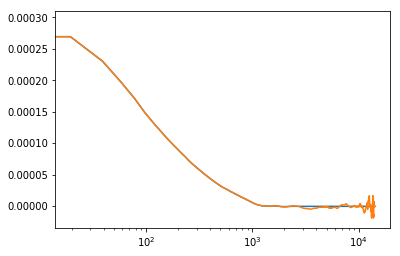

In [261]:
plate_ac_line_windowed = plate_ac_line*window
plt.semilogx(xaxis, plate_ac_line_windowed)
plt.semilogx(xaxis, plate_ac_line)

#### Now, the window function smoothly alters the autocorrelation function so that it vanishes where we have only a little information. 
#### We consider the window function a way of eliminating the effect of a very small sample size on the autocorrelation calculation. 
#### The statistical procudures used to estimate C[k] do not consider the fact that we are only sampling a small region of the sample, so the window function is a way to incorporate our information limitations into the analysis. 
#### If a larger region were subsequently scanned, it could be combined with our first measurement to provide an estimate of the autocorrelation function over more length scales. 

#### Next, we must convert the real-space patch potential autocorrelation functions into $k$-space autocorrelation functions. 

#### In most cases, the cross-correlation functions are neglected because only one surface or the other is measured. 

In [13]:
plate_ck, ks=p2d.convert_Cr_to_Ck( plate_ac_line, float(n8B_plate['cleannote']['dx']) )
plate_ck_w, ks=p2d.convert_Cr_to_Ck( plate_ac_line_windowed, float(n8B_plate['cleannote']['dx']) )

#### Behunin *et al.* PRA 2012 describes how to convert the autocorrelation function in real space C(r) to k-space C[k]:

$C_{ij}[k] = (2\pi)^{-1}\int_{0}^{\infty} rdr J_{0}(kr)C_{ij}(r)$,

#### where $J_{n}$ is an $\it{n}$-th order Bessel function

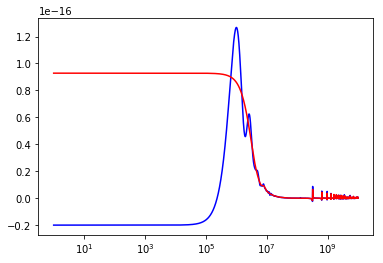

In [14]:
plt.semilogx(ks, plate_ck,'b')
plt.semilogx(ks, plate_ck_w,'r')

#### The windowing makes the C[k] representation of the autocorrelation function (red) much smoother at short separations, while at larger k, it still follows the un-windowed calculation (blue). The un-windowed function thus implies that the signal is anti-correlated at large distances, which is probably false. The windowed function is thus more consistent with the quasi local model of Buhunin et al 2012a.

#### We calculate the force from the surface. Then, if correlations between the two surfaces are negligible, then this is sufficient to calculate the total patch potential force. 

In [15]:
#this might give overflow warnings because of small values at large separations. 
separations = np.logspace(-7.7,-5,21)
press_plate = p2d.pressure_from_C11(plate_ck, ks, separations) 
press_plate_w = p2d.pressure_from_C11(plate_ck_w, ks, separations) 
#the vertical derivative of the pressure
#although we could just take a derivative to calculate it in the k-space representation, in the
#real-space representation the minimizing voltage differs between the force and force gradient
dpress_plate = p2d.dpressure_from_C11(plate_ck, ks, separations) 
dpress_plate_w = p2d.dpressure_from_C11(plate_ck_w, ks, separations) 

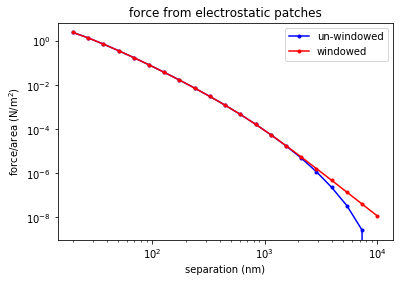

In [16]:
line1 = plt.loglog(separations*1e9, press_plate, 'b.-')
line2 = plt.loglog(separations*1e9, press_plate_w, 'r.-')
plt.title('force from electrostatic patches')
plt.ylabel('force/area (N/m$^{2}$)')
plt.xlabel('separation (nm)')
plt.legend( ('un-windowed', 'windowed'))
plt.show()

#### The un-windowed function thus leads to an unexpected repulsive force at 10 micron separation because it makes implicit assumptions about the auto-correlation function that we do not know. The force from the windowed autocorrelation function is consistent with the un-windowed up to about 1 micron, which is the largest separation that matters for our measurement, and it is more consistent with the forces predicted from Behunin's quasi-local model.

#### Assumptions about the relative orientation of the two surfaces is contained in the cross-correlation. These assumptions enter more naturally in the $r$ -space PFA framework, so we will discuss that term there. However, the cross-correlation term is where the electrostatic force from a surface-averaged potential enters. Roughly, for surfaces 1,2 at equipotentials 1,2: $C_{11}(r) = V_{1}^{2}, C_{22}(r) = V_{2}^{2}(r), C_{12}(r)=C_{21}(r)=V_{1} V_{2}$ in $\it{r}$-space. When transformed into $\it{k}$-space and input into for force formula, this again becomes the ordinary equation for the electrostatic force between conductors. I don't think any of the earlier papers explicitly pointed out that the Speake & Trenkel formulae can be used to calculate the electrostatic force with or without patches, *i.e.* it is not necessary to separate the potential into varying and unvarying components.

## Section III: The Disoriented Proximity Force Approximation (DPFA), or Derjaguin's Proximity Force Approximation

#### For Casimir force measurements between a sphere and a plate, the proximity force approximation (PFA) is typically used to compare the measured sphere-plate force to the calculated plate-plate energy (or force gradient to plate-plate force). When the force is thought to have minimal spatial variation, the PFA is straight-forward to apply: 

#### $F_{\text{PFA}} = 2 \pi R E_{pp}$, where $E_{pp}$ is the energy between parallel plates.
#### However, for the Force Modulation measurement technique collects data pertaining to the derivative of the force between a sphere and plate, rather than the force itself. Thus, the pertinent relationship is:
#### $\frac{F'_{\text{PFA}}}{R} = 2 \pi F_{pp}$,
#### where, similarly, $F_{pp}$ is the force per unit area between parallel plates.
#### See our 2018 *PRL* for more discussion of the PFA in studies of the Casimir force. 

In [17]:
def force_gradient( Fpp, R ):
    return 2*np.pi*R*Fpp

#normalizing by the sphere radius enables easier experiment-theory comparison:
def force_gradient_norm( Fpp):
    return 2*np.pi*Fpp

#### In Behunin *et al* *PRA* 2012, the PFA is used to compare a model of the electrostatic patch force (gradient) to a discrepancy between experimental data and two ways of calculating the Casimir force. While the basic PFA gives an estimate of the force itself, it does not provide an estimate of the bias voltage which minimizes the sphere-plate force. In Casimir experiments, the minimizing voltage is a key indicator about the presence of patch potential. Kim *et al* PRA 2010 discovered that because the minimizing voltage does not change in the plate-plate geometry, the above naive application of the PFA is not able to predict the  minimizing voltage. 

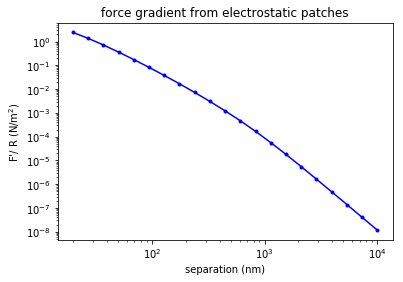

In [18]:
#line1 = plt.loglog(separations*1e9, press_plate, 'b.-')
fgsignal = map(force_gradient_norm,press_plate_w)
normalized = plt.loglog(separations*1e9, press_plate_w, 'b.-')
plt.title('force gradient from electrostatic patches')
plt.ylabel('F\'/ R (N/m$^{2}$)')
plt.xlabel('separation (nm)')
plt.show()

#### The PFA is used here with Derjaguin's approximation, only the leading order contribution in R is kept. Thus, only the curvature of the surface as closest approach matters. When numerically calculating the PFA, it is easier to maintain consistency if one keeps the whole calculation. Although this does not make the PFA more accurate, it makes it easier work with. Still, one must remember that numerical calculations are the PFA are not identical to Derjaguin's approximation. 

## Section IV: The oriented PFA (oPFA)

#### Although an exact formula for the patch potential force was calculated in Behunin *et al* *PRA* 2012b, which enable the prediction of the separation-dependent minimizing voltage, its computational requirements necessitated calculating with unphysically large, single scale patches. Our measurements of patch potentials (2015) showed that realistic models of patch potentials often contain irregular patches at several different length scales. Incorporating such a patch distribution into the Behunin2012b methodology is not feasible. Moreover, the length scales in the problem span 5 orders of magnitude, making finite element methods difficult.

#### Our strategy is instead to continue using the PFA, but instead of using Derjaguan's final formula, we instead numerically follow his integration, inspired by Sedmik *et al*'s PRB 2013 treatment of irregular roughness on colloidal probes. In that article, they divide the surface of the sphere into many little regions, which include roughness - peaks and valleys). Each tiny region is approximated as a parallel plate, and then the energy or force between the individual parallel plates is summed (for both the electrostatic and Casimir force approaches). We followed a similar approach to roughness in our recent article on the accuracy of Casimir force measurements.

#### However, it is not immediately obvious how to include patch potentials in a Sedmik-style analysis. The Speake & Trenkel formula for the patch potential force is phrases in $k$-space rather than position space. Therefore, we borrow a trick from image processing: filtering in position space rather than $k$ -space permits one to filter differently depending on spatial position. 

#### We rephrase the S&T formula in position space. Then the potential layer on surface is represented as a dipole layer. The energy from each surface has two contributions: (a) the dipole layer dot the potential from its image charge and (b) the dipole layer dot the potential charge from the opposite surface. Calculating the patch potential force then amounts to calculating the image potentials from each surface projected onto the other surface. Because we are calculating the force (and force gradient) between the surfaces, rather than the energy itself, the image potentials are transformed so that the electrostatic force can be phrased in very nearly the standard way. They way we phrase this is as follows:
#### $V_{i}$ - the potential on surface $i$
#### $\hat{V}_{ij}(d)$ - the $f$-transformed image potential from surface $i$ at surface $j$

#### In the limit of a uniform potential at surface $i$, $V_{ij}$ becomes $V_{i}$. To rephrase the force gradient as well as the force this way, we define the additional quantity ('$df$-transformed') $\hat{V}'_{ij}$ so that the standard force gradient equation can be used as well. Once all quantities are appropriately defined, we will have:
#### (1) $F = -\frac{\epsilon_{0}}{2}\iint{ \frac{\sum_{i,j=0,1}(-1)^{i+j}V_{i}\hat{V}_{ij}(h)dA}{h^{2}}}$
#### (2) $F' = \epsilon_{0}\iint \frac{\sum_{i,j=0,1}(-1)^{i+j}V_{i}\hat{V}'_{ij}(h)dA}{h^{3}}$,
#### where $h$ is the separation between the two plates for area $dA$.
#### When the potential on a surface is uniform, $\hat{V}_{ij}(d) = V_{i}$, which is a convenient property of phrasing the calculation this way.

#### To derive this formulation, we begin by re-phrasing the parallel plate calculation in r - space rather than k - space: 

#### $C_{ij}[k] = (2\pi)^{-1}\int_{0}^{\infty} dk J_{0}(kr)C_{ij}(r)$ 

#### $C_{ij}(r) = \frac{1}{2\pi A}\int\iint_{S} V_{i}(\vec{u})V_{j}(\vec{u}-r \cos (\theta) \hat{x} - r \sin (\theta) \hat{y} )d\vec{u}^{2}d\theta,$

#### where A is the area of surface S.

#### $F_{p} = \frac{-\epsilon_{0}}{2(2\pi)}\int \frac{k^{3}}{\sinh(kD)^{2}}\times$
#### $[(2\pi)^{-1}\int_{0}^{\infty} rdr J_{0}(kr)C_{11}(r)+ (2\pi)^{-1}\int_{0}^{\infty} rdr J_{0}(kr)C_{22}(r) -2(2\pi)^{-1}\int_{0}^{\infty} rdr J_{0}(kr)C_{12}(r) \cosh(k_{z}D)]dk$

#### which is unpleasantly long even before writing out the (auto)correlation functions in their integral form. We rewrite the whole integral so that the $k$ components are all in the innermost integrals, and the spatial integrals are the outermost integrals.

####  Because the pressure integral is the sum of 3 (or 4, depending on your point of view about $C_{21}$), we'll treat the terms separately: $C_{ii}$ first and then $C_{ij\neq i}$

#### $ \int_{0}^{\infty} \frac{k^{3}}{\text{sinh}(kD)^{2}}C_{ii}[k]dk$ 
#### $ =\int_{0}^{\infty} \frac{k^{3}}{\text{sinh}(kD)^{2}}(2\pi)^{-1}\int_{0}^{\infty}  J_{0}(kr)C_{ii}(r)rdrdk$ 
#### $ =\int_{0}^{\infty} \frac{k^{3}}{\text{sinh}(kD)^{2}}(2\pi)^{-1}\int_{0}^{\infty}  J_{0}(kr)\frac{1}{2\pi A}\int\iint_{S} V_{i}(\vec{u})V_{i}(\vec{u}-r \cos (\theta) \hat{x} - r \sin (\theta) \hat{y} )d\vec{u}^{2}d\theta rdrdk$ 

#### We pull the surface integral out from all of the other integrals so that it is in front
#### $ =\frac{1}{4\pi^{4}A}\iint_{S}V_{i}(\vec{u})\int_{0}^{\infty} \frac{k^{3}}{\text{sinh}(kD)^{2}}\int_{0}^{\infty} J_{0}(kr)\int V_{i}(\vec{u}-r \cos (\theta) \hat{x} - r \sin (\theta) \hat{y} )d\theta dr dk d\vec{u}^{2}$ 
#### Now, we focus on the inner integral again
#### $ =\int_{0}^{\infty} \frac{k^{3}}{\text{sinh}(kD)^{2}}\int_{0}^{\infty} rJ_{0}(kr)\int_{0}^{2\pi} V_{i}(\vec{u}-r \cos (\theta) \hat{x} - r \sin (\theta) \hat{y} )d\theta rdr dk $ 
#### $ =\int_{0}^{\infty} \int_{0}^{2\pi} [\int_{0}^{\infty} \frac{k^{3}dk}{\text{sinh}(kD)^{2}} rJ_{0}(kr)] V_{i}(\vec{u}-r \cos (\theta) \hat{x} - r \sin (\theta) \hat{y} )d\theta rdr $ 

#### We then transform back to Cartesian coordinates and re-write the integral over k as the (radially-symmetric) function a($\vec{x}$)
#### $ =\iint a(\vec{x}) V_{i}(\vec{u}-\vec{x} )d \vec{x}^{2}$
#### This is now a convolution which we can write as $W_{i}(\vec{u})=\iint a(\vec{x}) V_{i}(\vec{u}-\vec{x} )d \vec{x}^{2}$, so that the whole integral becomes:
#### $\iint_{S} V_{i}(\vec{u})W_{i}(\vec{u}) d\vec{u}$
#### Once the convolution kernel $a$ is calculated, all of the operations are now performed in real space, so this formulation of the mathematics is appropriate for incorporation into the PFA.

#### We define a few slightly different radially-symmetric functions so that the spatial convolution allows us to perform calculations in the form of equations (1) and (2). They are derived the same way as $a$ was above, up to a prefactor.
#### $g_{i,j=i}(h,r,\theta) = \frac{\pi h^{4}}{2 r}\int_{0}^{\infty} \frac{{k}^{3}}{\sinh(kh)^{2}}J_{0}(kr)dk$
#### $g_{i,j\neq i}(h,r,\theta) = \frac{\pi h^{4}}{2 r}\int_{0}^{\infty} \frac{{k}^{3}\cosh(kh)}{\sinh(kh)^{2}}J_{0}(kr)dk$
#### $g'_{i,j= i}(h,r,\theta) = \frac{\pi h^{5}}{2 r}\int_{0}^{\infty} \frac{{k}^{4}\cosh(kh)}{\sinh(kh)^{3}}J_{0}(kr)dk$
#### $g'_{i,j \neq i}(h,r,\theta) = \frac{\pi h^{5}}{4 r}\int_{0}^{\infty} \frac{{k}^{4}(\cosh(kh)^{2}+1)}{\sinh(kh)^{3}}J_{0}(kr)dk$

#### Then the transformed image potentials can be written as:
#### $\hat{V}_{ij} = g_{ij}(h)*V_{i},$
#### where '$*$' is the convolution operator, and
#### $\hat{V}'_{ij} = g'_{ij}(h)*V_{i}$

## What do the convolution operators look like spatially?
#### This will take a minute.

In [19]:
#we set everything to a height of 100 nm, use 35x35 images, and set the spacing to the spacing of the KPFM images
import filters3D as filt3
import force3D as f3
h_values = np.logspace(-7.7,-5,21) #gives values in powers of 10^n
gii_packed = filt3.complete_filtering([1e-7],35, 'fs', float(n8B_plate['cleannote']['dx']))
gii = filt3.make_calc_filters(gii_packed)
gij_packed = filt3.complete_filtering([1e-7],35, 'fo', float(n8B_plate['cleannote']['dx']))
gij = filt3.make_calc_filters(gij_packed)
gpii_packed = filt3.complete_filtering([1e-7],35, 'fds', float(n8B_plate['cleannote']['dx']))
gpii = filt3.make_calc_filters(gpii_packed)
gpij_packed = filt3.complete_filtering([1e-7],35, 'fdo', float(n8B_plate['cleannote']['dx']))
gpij = filt3.make_calc_filters(gpij_packed)
g_filters = [gii, gij, gpii, gpij]

100%|██████████| 1/1 [00:06<00:00,  6.08s/it]
1it [00:00, 482.10it/s]
100%|██████████| 1/1 [00:07<00:00,  7.09s/it]
1it [00:00, 513.00it/s]
100%|██████████| 1/1 [00:06<00:00,  6.77s/it]
1it [00:00, 750.32it/s]
100%|██████████| 1/1 [00:07<00:00,  7.35s/it]
1it [00:00, 421.67it/s]


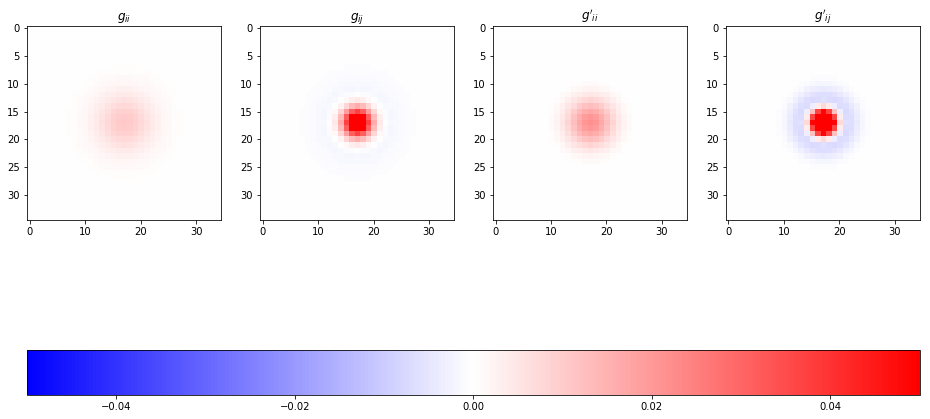

In [20]:
fig, ax = plt.subplots(1,4, figsize = (16,16))
a0 = ax[0].imshow(gii[1e-7], vmin = -.05, vmax =  .05, cmap = 'bwr')
fig.colorbar(a0, ax = ax, orientation = 'horizontal')#, orientation = 'horizontal', ax = ax[0])
ax[0].set_title('$g_{ii}$')
a1 = ax[1].imshow(gij[1e-7],vmin = -.05, vmax =  .05, cmap = 'bwr')
ax[1].set_title('$g_{ij}$')
#harmonic mixing atomic force microscopyfig.colorbar(a1, orientation = 'horizontal', ax = ax[1])
a2 = ax[2].imshow(gpii[1e-7],vmin = -.05, vmax =  .05, cmap = 'bwr')
#fig.colorbar(a2, orientation = 'horizontal', ax = ax[2])
ax[2].set_title('$g\'_{ii}$')
a3 = ax[3].imshow(gpij[1e-7],vmin = -.05, vmax =  .05, cmap = 'bwr')
ax[3].set_title('$g\'_{ij}$')
#fig.colorbar(main, orientation = 'horizontal')
plt.show()

## Properties of the filters
#### (1) $g_{ii}$ is non-negative (but the others are not)
#### (2) The integral over any of the filters is 1, so a uniform potential is not changed by convolution.

## The appearance of the filtered KPFM images,
#### Plotted at 100 nm separation

In [149]:
kpfms = [filt3.KPFMimagefilter(plate_clean, i[1e-7]) for i in g_filters]

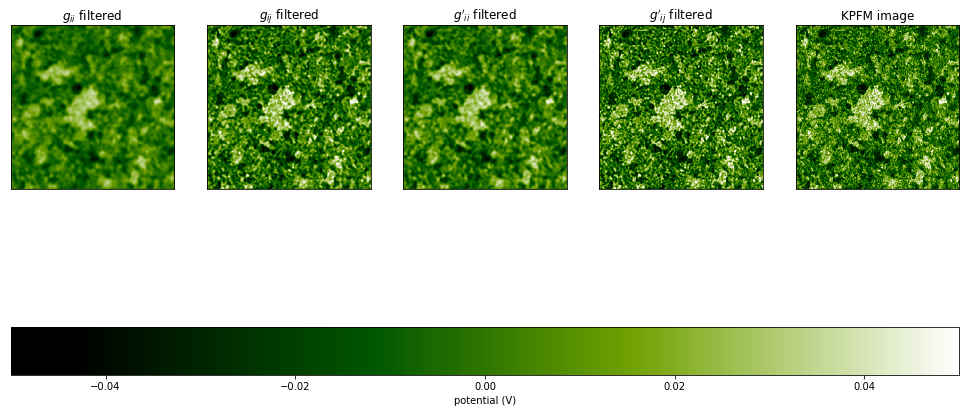

In [150]:
fig, ax = plt.subplots(1,5, figsize=(17,17))
for i in range(4):
    ax[i].imshow(kpfms[i], vmin = -0.05, vmax = .05, cmap = 'Chlorophyll')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

ax[0].set_title('$g_{ii}$ filtered')
ax[1].set_title('$g_{ij}$ filtered') 
ax[2].set_title('$g\'_{ii}$ filtered') 
ax[3].set_title('$g\'_{ij}$ filtered') 
a4 = ax[4].imshow(plate_clean, vmin = -0.05, vmax = .05, cmap = 'Chlorophyll')
ax[4].set_xticks([])
ax[4].set_yticks([])
ax[4].set_title('KPFM image')
cb = fig.colorbar(a4, ax = ax, orientation = 'horizontal')
cb.set_label('potential (V)')
plt.show()

## Comparing to the C[k] calculation of force
#### Unfortunately, to calculate the force out to a micron, we will need a large filter ($243^{2}$ pixels) 
#### This calculation will take about 30 minutes on a 2015 laptop.
#### You only need to run this calculation once, because the matrices are constant for a given size of separation and pixel spacing.

In [151]:
h_values = np.logspace(-7.7,-5,21) #gives values in powers of 10^n
####uncomment next lines to run
#gii_packed = filt3.complete_filtering(h_values,243, 'fs', float(n8B_plate['cleannote']['dx']))
#giis = f3.make_calc_filters(gii_packed)

In [152]:
#### It can be worthwhile to save the gii_files
#### We're just going to save them as a pickle, locally
#### Now, you can skip the preceding box if you run this again
#import pickle
#pickle.dump(gii_packed,open('gii_packed.pkl','wb') )

In [153]:
import pickle
gii_packed = pickle.load(open('gii_packed.pkl','rb'))
giis = filt3.make_calc_filters(gii_packed)

21it [00:01, 16.37it/s]


In [154]:
#### Calculating the KPFM maps also takes about 20 minutes
#uncomment next line to run
#all_filtered = filt3.allfilteredImages(plate_clean, gii_packed)

In [155]:
#### Saving the filtered images:
#import pickle
#pickle.dump(all_filtered,open('plate_filtered.pkl','wb') )

In [156]:
#### Load filtered images:
import pickle
all_filtered = pickle.load(open('plate_filtered.pkl','rb'))

In [157]:
#Filtered in real space
forces = [pp.ES_force_1term( all_filtered[x]-all_filtered[x].mean(), plate_clean-plate_clean.mean(), x) for i, x in enumerate(gii_packed['separation'])]
#Unfiltered forces
forces2 = [pp.ES_force_1term( plate_clean, plate_clean, x) for i, x in enumerate(gii_packed['separation'])]

In [158]:
#The sphere-plate separations that we'll be using
sph_h = np.ones(plate_clean.shape)*gii_packed['separation'][1]
#the spacing of pixels
dx = float(n8B_plate['cleannote']['dx'])
#for these calculations, we use a null potential for the potentials that we do not have
v1_hat = np.zeros(plate_clean.shape)
v2 = np.copy(v1_hat)
f2 = f3.force_from_heights( sph_h, dx, plate_clean, all_filtered[h_values[1]], v1_hat, v2, v2, v2 )

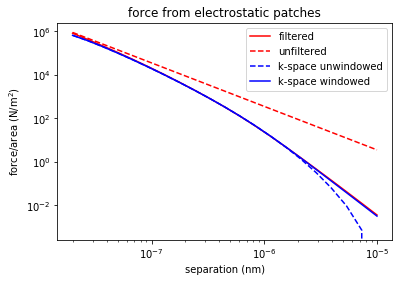

In [159]:
plt.loglog(gii_packed['separation'], forces, 'r-')
plt.loglog(gii_packed['separation'], forces2, 'r--')
plt.loglog(separations, press_plate*(512)**2, 'b--')
plt.loglog(separations, press_plate_w*(512)**2, 'b-')
plt.title('force from electrostatic patches')
plt.ylabel('force/area (N/m$^{2}$)')
plt.xlabel('separation (nm)')
plt.legend( ('filtered', 'unfiltered', 'k-space unwindowed', 'k-space windowed'))
plt.show()

#### The patch potential force from the full spatial calculation (solid red) aligns very closely with the patch potential force from the (windowed) k-space calculation (solid blue). The un-filtered spatial calculation (red dashed) significantly overestimates the force, while the un-windowed k-space calculation is accurate out to about 1 micron. This is because, in the spatial calculation, the lack of knowledge about the autocorrelation function at separations of larger than 1 micron or so is 'automatically' incorporated into the calculation.

In [160]:
####uncomment next lines to run
#gpii_packed = filt3.complete_filtering(h_values,243, 'fds', float(n8B_plate['cleannote']['dx']))
#gpiis = filt3.make_calc_filters(gpii_packed)
#pickle.dump(gpii_packed,open('gpii_packed.pkl','wb') )

In [161]:
gpii_packed = pickle.load(open('gpii_packed.pkl','rb'))

In [162]:
#### Calculating the KPFM maps also takes about 20 minutes
#### uncomment next line to run
#fds_filtered = filt3.allfilteredImages(plate_clean, gpii_packed)
#pickle.dump(fds_filtered,open('plate_filtered_fds.pkl','wb') )

In [163]:
fds_filtered = pickle.load(open('plate_filtered_fds.pkl','rb'))

In [164]:
#plot the force gradient comparison

# Patches on a sphere
#### The spatial calculation of the patch potential force allows us to adapt the calculation for curved surfaces with the proximity force approximation (PFA) . The PFA is the assumption that the force between two surfaces is the sum of the individual nearly-parallel portions of a surface. The commonly used Derjaguin approximation is the leading-order term of the PFA in the radius of curvature. For numerical calculations, the full PFA, without Derjaguin's additional approximation, is used.

#### The first task is to determine the geometry of the interacting surfaces. 

In [165]:
sph = pp.spheremap(2.46e-5, 512, float(n8B_plate['cleannote']['dx']))

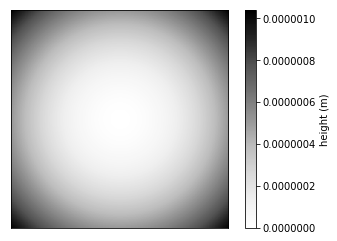

In [166]:
#Here, the white area shows where the sphere comes into contact with the plate
#The dark regions are further from the plate
fig, ax = plt.subplots(1,1)
m1 = ax.imshow(sph, cmap = "Greys")
ax.set_xticks([])
ax.set_yticks([])
cb = fig.colorbar(m1, label = "height (m)")
plt.show()

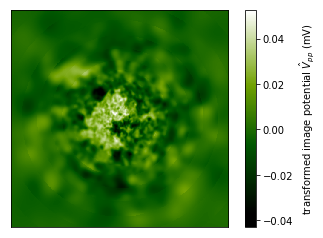

In [167]:
#To put patches on the sphere, we must first raise it up a little from the surface
sph_h = sph + 30e-9
filtered_patches = pp.patches_on_sphere2(sph_h, all_filtered)
fig, ax = plt.subplots()
plot = ax.imshow(filtered_patches, cmap = "Chlorophyll")
fig.colorbar(plot, label = "transformed image potential $\hat{V}_{pp}$ (mV)")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

#### The transformed image potential on a sphere is calculated by combining the transformed image potentials at different separations, according to the local sphere-plate separation

#### One of the major differences between the parallel-plate patch potential force and the sphere-plate patch potential force is that the minimizing voltage now changes with separation (shown in Kim et al PRA 2010). Thus, the minimizing voltage needs to be calculated at each separation. In the experiment, the minimizing voltage is determined by grounding the plate and letting the voltage of the sphere vary. We follow the same procedure in calculating the minimizing voltage from the KPFM data. 

#### Because a constant offset voltage applied to either surface is preserved by all the $g$ convolutions, we can say:
$\frac{d\hat{V}_{sj}}{dV_{a}} = \frac{dV_{s}}{dV_{a}}, \frac{d\hat{V}'_{sj}}{dV_{a}} = \frac{dV_{s}}{dV_{a}}$
#### and
$\frac{d\hat{V}_{pj}}{dV_{a}} = 0, \frac{d\hat{V}'_{pj}}{dV_{a}} = 0$,
#### where $V_{a}$ is the external voltage applied to the sphere.

#### Then the minimizing voltages for both the force and force gradient are:
#### (3) $V_{m} = \frac{\frac{1}{2}\iint \frac{V_{p}+\hat{V}_{ps}(h)-V_{s}-\hat{V}_{ss}(h)dA}{h^{-2}}}{\frac{\iint dA}{h^{-2}}}$

#### (4) $V'_{m} = \frac{\frac{1}{2}\int\int \frac{V_{p}+\hat{V}'_{ps}(h)-V_{s}-\hat{V}'_{ss}(h)dA}{h^{-3}}}{\frac{\int\int dA}{h^{-3}}}$

#### It is straight-forward to check the case for constant potential. Note that by phrasing the calculation in terms of the transformed image potential, we have made these analytic formulae simple to derive and inspect.

#### Now, we must actually do the calculation...

#### From here on, we will begin to use the functions written for the analysis in the paper. Essentially, we wrap all of the information about the sphere and the plate in a class called a surface, from which we calculate the parameters we are interested in. For now, we will model the sphere as a grounded, patchless surface. 

In [168]:
#### defining the null surfaces
null_KPFM = np.zeros((512,512))
null_pot = {i:np.zeros((512,512)) for i in h_values}
one_pot = {i:np.ones((512,512)) for i in h_values}

In [197]:
#### defining the sphere and the plate
null_sphere = f3.sphere(null_KPFM, fs = null_pot, fo = null_pot, R = 2.46e-5, dx = 1e-5/512 )
plate =f3.surface(plate_clean, fs = all_filtered, fo = null_pot)

In [198]:
#### We must define where the point of closest approach between the sphere and the plate will be 
#### because our function creates and adjusts the 'height' image based on this location
center = [(256,256)]

In [199]:
#### The force and the minimizing voltage are calculated simultaneously
#### The patch potential force is then calculated at the minimizing voltage
test = (f3.calcForceData( null_sphere, plate, center, h_values))
v0s = test['v0f']['s00p00']
force = test['f']['s00p00']

0it [00:00, ?it/s]

forces


1it [00:01,  1.97s/it]


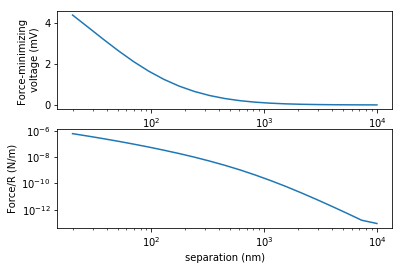

In [200]:
fig, ax = plt.subplots(2,1)
ax[0].semilogx(1e9*h_values, 1e3*v0s)
ax[0].set_ylabel('Force-minimizing \nvoltage (mV)')
ax[1].loglog(1e9*h_values, force/2.46e-5)
ax[1].set_xlabel('separation (nm)')
ax[1].set_ylabel('Force/R (N/m)')
plt.show()

#### To compare the real-space PFA sphere-plate calculation to the k-space calculation, we have to use $\hat{V}'_{pp}$

In [220]:
plate =f3.surface(plate_clean, fs = all_filtered, fo = null_pot, fds = fds_filtered, fdo = null_pot)
null_sphere = f3.sphere(null_KPFM, fs = null_pot, fo = null_pot,
                        fds = null_pot, fdo =  null_pot, R = 2.46e-5, dx = 1e-5/512)

In [240]:
fgrad = (f3.calcForceData( null_sphere, plate, center, h_values))
v0sfg = fgrad['v0df']['s00p00']
forceg = fgrad['df']['s00p00']

0it [00:00, ?it/s]

forces


1it [00:02,  2.09s/it]
0it [00:00, ?it/s]

force gradients


1it [00:03,  3.12s/it]


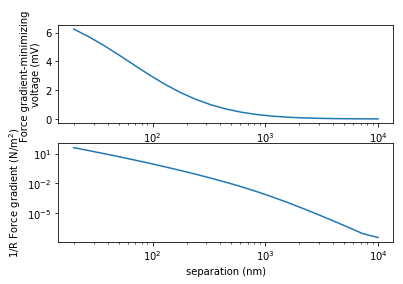

In [241]:
fig, ax = plt.subplots(2,1)
ax[0].semilogx(1e9*h_values, v0sfg*1e3)
ax[1].loglog(1e9*h_values, forceg/2.46e-5)
ax[0].set_ylabel('Force gradient-minimizing \nvoltage (mV)')
ax[1].set_xlabel('separation (nm)')
ax[1].set_ylabel('1/R Force gradient (N/m$^{2}$)')
plt.show()

In [242]:
#### plt.loglog(separations, press_plate_w*(512)**2, 'b-')
fg_PFA_kspace = force_gradient_norm(press_plate_w)
#### Calculating the force gradient between a sphere and the plate

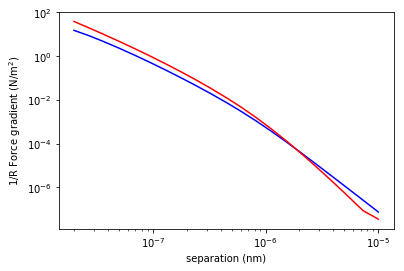

In [243]:
#### Comparing the force gradient to the C[k] + dPFA force gradient
plt.loglog(h_values, fg_PFA_kspace, 'b')
plt.loglog(h_values, forceg/2.46e-5, 'r')
plt.xlabel('separation (nm)')
plt.ylabel('1/R Force gradient (N/m$^{2}$)')
plt.show()

#### Although the agreement between the force gradient calculated from the C[k]-PFA and the real space PFA is quite good, there is some discrepancy at short separations. The C[k] PFA calculation of the sphere-plate patch potential force is a (weighted) average over many possible orientations of the sphere. The large patch close to the point of least separation on our sphere causes our real-space estimate to be slightly larger than the k-space estimate. While sensitivity to the choice of least separation might initially seem to be a problem with the real-space method, it is actually an advantage, because it permits the calculation of uncertainty...

## Section V: Uncertainty in the OPFA

In [230]:
#### Spheres with many different points of closest approach (do 16, widely spaced)
mygrid = f3.make_grid( (256,256), 342, 3)
sphere_images = [pp.spheremap(2.46e-5, 512, 1e-5/512, center=i) for i in mygrid]

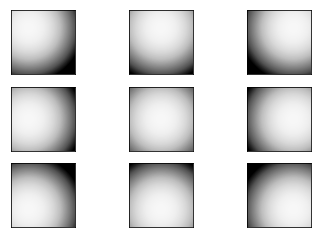

In [231]:
fig, ax = plt.subplots(3,3)
for i in range(9):
    ax[i//3, i%3].imshow(sphere_images[i], cmap = "Greys", vmin = -10e-8, vmax =1.5e-6)
    ax[i//3, i%3].set_xticks([])
    ax[i//3, i%3].set_yticks([])

In [232]:
sphere_fs_patches = [pp.patches_on_sphere2(i+3e-8, all_filtered) for i in sphere_images]

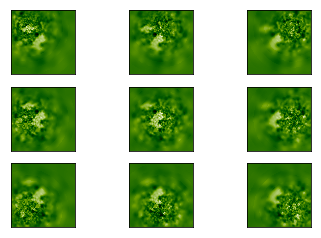

In [233]:
fig, ax = plt.subplots(3,3)
for i in range(9):
    ax[i//3, i%3].imshow(sphere_fs_patches[i], cmap = "Chlorophyll", vmin = -5e-2, vmax =5e-2)
    ax[i//3, i%3].set_xticks([])
    ax[i//3, i%3].set_yticks([])

In [234]:
sphere_fds_patches = [pp.patches_on_sphere2(i+3e-8, fds_filtered) for i in sphere_images]

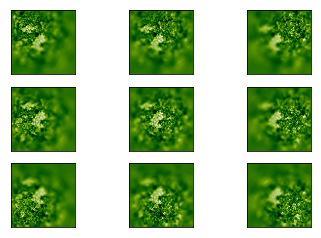

In [235]:
#### The $\hat{V}'_{pp}$ for the many possible orientations
fig, ax = plt.subplots(3,3)
for i in range(9):
    ax[i//3, i%3].imshow(sphere_fds_patches[i], cmap = "Chlorophyll", vmin = -5e-2, vmax =5e-2)
    ax[i//3, i%3].set_xticks([])
    ax[i//3, i%3].set_yticks([])

#### The automated patch potential calculation loops over all different orientations for both the upper sphere and the lower sphere. Thus there are 81 possible orientations, rather than 9. The purpose of this extra loop becomes more apparent when we include the patches on the sphere.

In [248]:
fgrad = (f3.calcForceData( null_sphere, plate, mygrid, h_values, justOne = True))

0it [00:00, ?it/s]

forces


9it [00:22,  2.79s/it]
0it [00:00, ?it/s]

force gradients


9it [00:36,  4.41s/it]


In [249]:
fgrad2 = (f3.calcForceData( null_sphere, plate, mygrid, h_values, justOne = True))

0it [00:00, ?it/s]

forces


9it [00:21,  2.55s/it]
0it [00:00, ?it/s]

force gradients


9it [00:36,  4.44s/it]


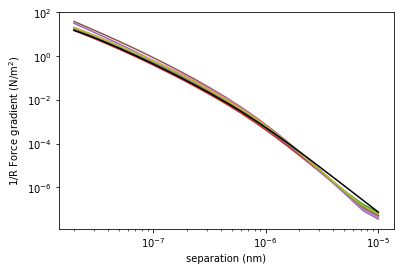

In [250]:
#The DPFA falls slightly outside of the range of the oriented PFA
#Because the DPFA uses the Derjaguin approximation in addition to the plain PFA,
#it falls outside the range at separations > 1 micron
#Note that the plain PFA and Derjaguins's approximation are similarly inaccurate for the
#(uniform-voltage) electrostatic force between a sphere and a plate. The first 
#underestimates the force, and the second overestimates the force
calclabels = {'s00p00','s00p01','s00p02','s00p03','s00p04','s00p05','s00p06','s00p07','s00p08'}
for i in calclabels:
    plt.loglog(h_values, fgrad2['df'][i]/2.46e-5)
    
plt.loglog(h_values, fg_PFA_kspace, 'black')
plt.xlabel('separation (nm)')
plt.ylabel('1/R Force gradient (N/m$^{2}$)')
plt.show()

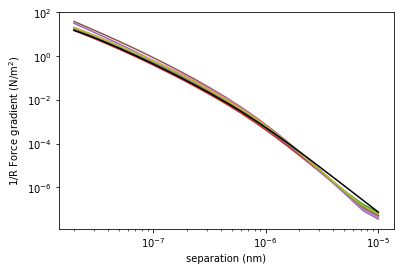

In [251]:
#The DPFA falls slightly outside of the range of the oriented PFA
#Because the DPFA uses the Derjaguin approximation in addition to the plain PFA,
#it falls outside the range at separations > 1 micron
#Note that the plain PFA and Derjaguins's approximation are similarly inaccurate for the
#(uniform-voltage) electrostatic force between a sphere and a plate. The first 
#underestimates the force, and the second overestimates the force
calclabels = {'s00p00','s00p01','s00p02','s00p03','s00p04','s00p05','s00p06','s00p07','s00p08'}
for i in calclabels:
    plt.loglog(h_values, fgrad['df'][i]/2.46e-5)
    
plt.loglog(h_values, fg_PFA_kspace, 'black')
plt.xlabel('separation (nm)')
plt.ylabel('1/R Force gradient (N/m$^{2}$)')
plt.show()

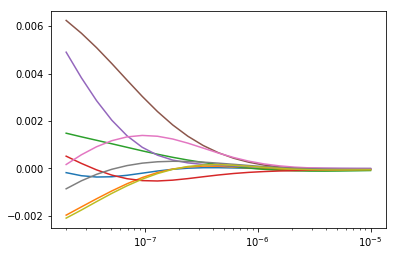

In [252]:
#### For this sampling of points, we calculate that force gradient minimizing voltage
for i in calclabels:
    plt.semilogx(h_values, fgrad['v0df'][i])

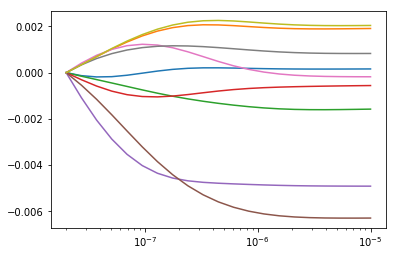

In [253]:
#In our experiments, there is often an overall voltage offset in electronics used to
#determining the force gradient minimizing voltage. 
#To permit better comparison of experiment to theory, then, we look at the difference in 
#the minimizing voltage from its value at the closest approach
for i in calclabels:
    plt.semilogx(h_values, fgrad['v0df'][i]-fgrad['v0df'][i][0])

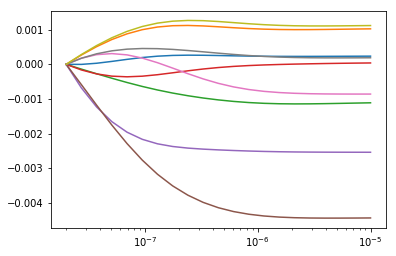

In [254]:
# The change in the force-minimizing voltage is slightly less but follows a similar pattern
for i in calclabels:
    plt.semilogx(h_values, fgrad['v0f'][i]-fgrad['v0f'][i][0])

#### The electrostatic force gradient calculations based on our KPFM measurements show that the electrostatic patch potential force gradient is significantly less than the Casimir force. The measurements of the force-minimizing and force gradient-minimizing voltages are used to further verify that our measurements and interpretation are accurate. 

## Section VI: Including the sphere
#### The new information included in this paper is the measurement of the patches on the sphere.
#### This is how we incorporate them into the analysis.

## Cleaning the sphere image.
#### Note that the length is 10 microns on each side.

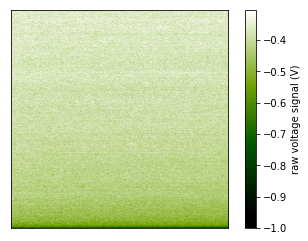

In [255]:
sphere_KPFM = ck.get_image(n8B_sphere, 'UserIn1Retrace')
fig, ax = plt.subplots()
myfig = ax.imshow(sphere_KPFM.transpose(), cmap = 'Chlorophyll', vmin = -1)
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(myfig, ax = ax, label = 'raw voltage signal (V)')
plt.show()

#### The huge variation in voltage with time is because the probe it the sphere on the first line of the image
#### Now, when the sphere KPFM image is cleaned, a few more points must be median-filled

In [256]:
avg = ck.avg_kpfms(n8B_sphere)
sphere_ckpfm = ck.clean_kpfms(n8B_sphere)

image already loaded
nans: 780, trace: 0, retrace: 0, both: 261364
image already loaded


#### However, because the median filter preserves boundaries, and because the number of bad pixels is < 0.3% of the total pixels, the structure of the patches is retained. 

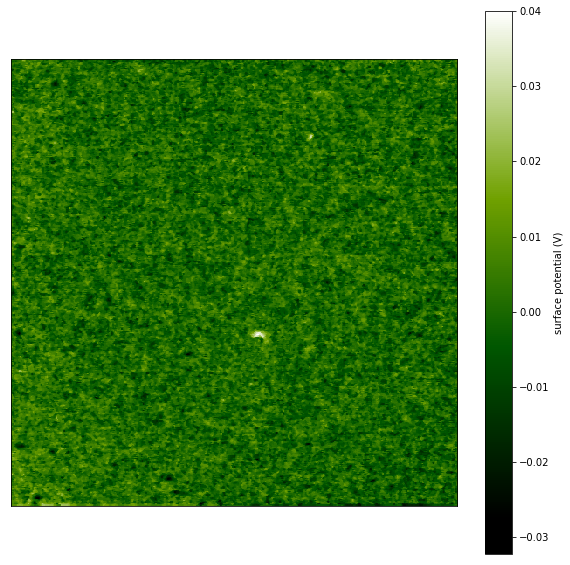

In [257]:
#for now, just note that the length is 10 microns on each side
fig, ax = plt.subplots(figsize=(10,10))
myfig = ax.imshow(sphere_ckpfm.transpose(), cmap = 'Chlorophyll')
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(myfig, ax = ax, label = 'surface potential (V)')
plt.show()

#### The immediate impression of the sphere data is that it is much less patchy than the plate data. This is for two reasons. First, because the sphere-on-a-cantilever probe is very sensitive and scanning too close to its surface causes it to oscillate wildly, the KPFM data collected on the sphere, although collected with H-KPFM, were acquired at a larger average separation than on the plate, which harms the spatial resolution. Secondly, the reciped for the gold deposition on the sphere, because of extremely large initial patches, had more effort go into its optimization than the deposition on the plate. 

#### The next step is to calculate the filters for the opposite-surface interaction ($g_{ij}'$). The first time you do this, you'll need to uncomment the following box. After that, recomment it and load the filters if you run it again.

In [194]:
#gpij_packed = filt3.complete_filtering(h_values,243, 'fdo', float(n8B_plate['cleannote']['dx']))
#gpijs = filt3.make_calc_filters(gpij_packed)

In [195]:
import pickle
#pickle.dump(gpij_packed,open('gpij_packed.pkl','wb') )
gpij_packed = pickle.load(open("gpij_packed.pkl", "rb"))

#### Similarly, calculate the sphere V_{ii}' and V_{ij}' once, and then in the future load them.
#### They are calculated on your computer, rather than stored online, because they are large files and because it would be best for you to see how they are calculated.

In [196]:
#sph_fds = filt3.allfilteredImages(sphere_ckpfm, gpii_packed)
#pickle.dump(sphere_fds,open('sphere_fds.pkl','wb'))

In [70]:
sph_fds = pickle.load(open('sphere_fds.pkl', 'rb'))

In [71]:
#sph_fdo = filt3.allfilteredImages(sphere_ckpfm, gpij_packed)
#pickle.dump(sphere_fdo,open('sphere_fdo.pkl','wb'))

In [72]:
sph_fdo = pickle.load(open('sphere_fdo.pkl', 'rb'))

In [73]:
#plate_fdo = filt3.allfilteredImages(plate_clean, gpij_packed)
#pickle.dump(plate_fdo,open('plate_fdo.pkl','wb'))

In [74]:
plate_fdo = pickle.load(open('plate_fdo.pkl', 'rb'))

#### Now, we can define the surfaces:

In [75]:
plate =f3.surface(plate_clean, fs = all_filtered, fo = null_pot, fds = fds_filtered, fdo = plate_fdo)
sphere = f3.sphere(sphere_ckpfm, fs = null_pot, fo = null_pot,
                        fds = sph_fds, fdo =  sph_fdo, R = 2.46e-5, dx = 1e-5/512)

In [76]:
fgrad = (f3.calcForceData( null_sphere, plate, center, h_values))
v0sfg = fgrad['v0df']['s00p00']
forceg = fgrad['df']['s00p00']

0it [00:00, ?it/s]

forces


1it [00:01,  1.94s/it]
0it [00:00, ?it/s]

force gradients


1it [00:03,  3.03s/it]


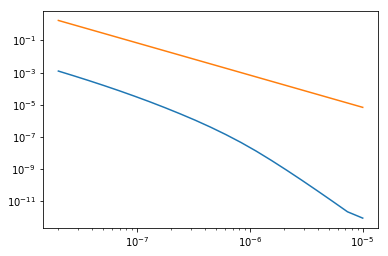

In [85]:
plt.loglog(h_values, forceg)
standard = 8.85e-12*np.pi*2.46e-5/(h_values)**2
plt.loglog(h_values, standard)

In [86]:
fgrad_sp = f3.h5_to_dictionaries('savedforcedata.hdf5')

In [87]:
#this will take a few minutes
#fgrad_sp = (f3.calcForceData( sphere, plate, mygrid, h_values))
#save the data once your calculations are complete
#f3.fullforcesave('savedforcedata.hdf5', mygrid ,fgrad_sp, h_values)

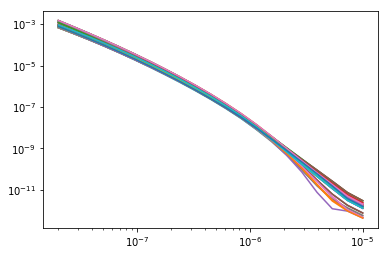

In [88]:
for i in fgrad_sp['df']:
    if i == 'Title':
        break
    plt.loglog(h_values, fgrad_sp['df'][i])

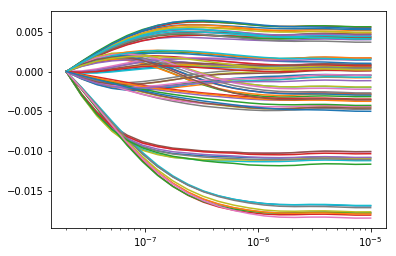

In [89]:
for i in fgrad_sp['v0df']:
    plt.semilogx(h_values, fgrad_sp['v0df'][i]-fgrad_sp['v0df'][i][0])

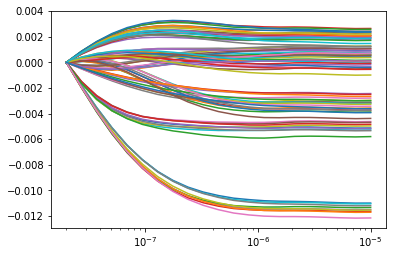

In [90]:
# The change in the force-minimizing voltage is slightly less but follows a similar pattern
for i in fgrad_sp['v0f']:
    plt.semilogx(h_values, fgrad_sp['v0f'][i]-fgrad_sp['v0f'][i][0])

In [262]:
#Filtered in real space
dforces = [ES_forceg_1term( fds_filtered[x]-fds_filtered[x].mean(), plate_clean-plate_clean.mean(), x) for i, x in enumerate(gii_packed['separation'])]

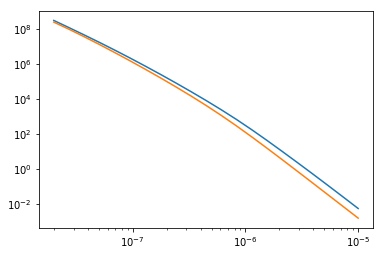

In [263]:
plt.loglog(h_values, np.array(dforces)/(512)**2)
plt.loglog(h_values, dpress_plate_w)

In [139]:
one_plate =f3.surface(np.ones_like(null_KPFM), fs = one_pot, fo = one_pot, fds = one_pot, fdo = one_pot)
null_sphere = f3.sphere(null_KPFM, fs = null_pot, fo = null_pot,
                        fds = null_pot, fdo =  null_pot, R = 2.46e-5, dx = 1e-5/512)

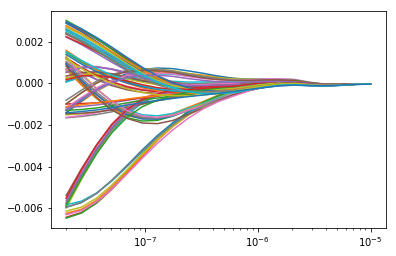

In [140]:
# The difference between the force-minimizing voltage and the force gradient-minimizing voltage
for i in fgrad_sp['v0f']:
    plt.semilogx(h_values, fgrad_sp['v0f'][i]-fgrad_sp['v0df'][i])

In [141]:
one_plate =f3.surface(np.ones_like(null_KPFM), fs = one_pot, fo = one_pot, fds = one_pot, fdo = one_pot)
null_sphere = f3.sphere(null_KPFM, fs = null_pot, fo = null_pot,
                        fds = null_pot, fdo =  null_pot, R = 2.46e-5, dx = 1e-5/512)

In [218]:
fgrad = (f3.calcForceData( null_sphere, one_plate, center, h_values, extpot = 1, vset = 0, wsph = 1))
v0sfg = fgrad['v0df']['s00p00']
forceg = fgrad['df']['s00p00']
force = fgrad['f']['s00p00']

0it [00:00, ?it/s]

forces


1it [00:02,  2.07s/it]
0it [00:00, ?it/s]

force gradients


1it [00:03,  3.03s/it]


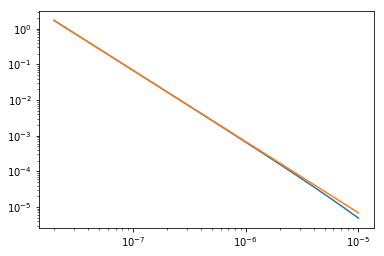

In [219]:
plt.loglog(h_values, forceg)
standard = 8.85e-12*np.pi*2.46e-5/(h_values)**2
plt.loglog(h_values, standard)

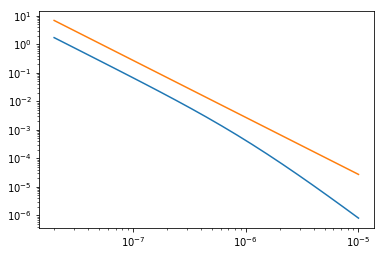

In [147]:
plt.loglog(h_values, forceg)
standard = 8.85e-12*np.pi*2.46e-5/(h_values)**2*4
plt.loglog(h_values, standard)

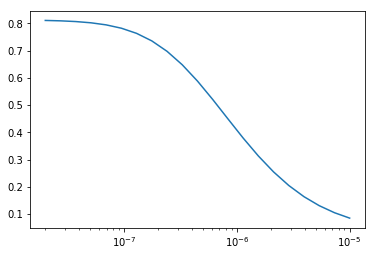

In [124]:
plt.semilogx(h_values,v0sfg)

In [214]:
import importlib
importlib.reload(f3)

<module 'force3D' from '/home/joe/repos/pfapatchpotentials/PFApatchpotentials/force3D.py'>

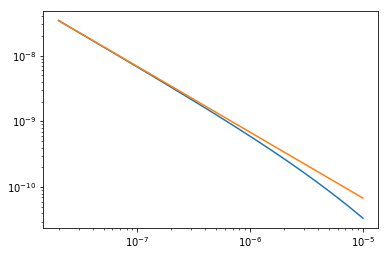

In [215]:
plt.loglog(h_values, force)
standard = 8.85e-12*np.pi*2.46e-5/(h_values)
plt.loglog(h_values, standard)

In [244]:
fgrad = (f3.calcForceData( null_sphere, one_plate, center, h_values, extpot = 1, vset = 0, wsph = 0, ras = 1))
v0sfg = fgrad['v0df']['s00p00']
forceg = fgrad['df']['s00p00']
force = fgrad['f']['s00p00']

0it [00:00, ?it/s]

forces


1it [00:02,  2.11s/it]
0it [00:00, ?it/s]

force gradients


1it [00:03,  3.07s/it]


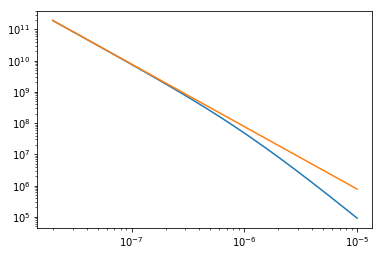

In [245]:
plt.loglog(h_values, forceg)
standard = np.pi*2.46e-5/(h_values)**2
plt.loglog(h_values, standard)

In [213]:
import numpy as np
import tables as tb
from scipy import constants
import patchpotentials as pt
import tqdm

def ES_forceg_1term(v1,v2,d):
    #constants.epsilon_0
    try:
        len(d)
    except TypeError:
        d = np.zeros(v1.shape)+d
        
    try:
        len(v2)
    except TypeError:
        v2 = np.zeros(v1.shape)+v2
    
    force2sum = constants.epsilon_0*v1*v2/d**3
    
    return np.sum(force2sum)

In [131]:
null_sphere.R

2.46e-05